# Project Instructions: Station Keeping using Reinforcement Learning

The goal of this project is to maintain a space station in low Earth orbit (LEO) using a combination of reinforcement learning techniques to make high level decisions and conventional engineering principles. The environment simulates the orbital dynamics, attitude control and fuel consumption of the station. In this fictional scenario the space station has started to saturate its passive attitude control schemes. The station now relies on more expensive maneuvering thrusters until the next desaturation operating operation can occur during a refueling operation which is scheduled to arrive in 6 months. The space station is in a decaying orbit due to friction from the upper layers of the atmosphere (the drag coefficient changes based on the attitude). Additional disturbances include solar radiation and noise in the valve thurster sensors and actuators. The project will test all your skills and abilities that acquired during the course including model classification, simulation, optimization and control.

The ultimate goal is to maintain orbit for the required 6 months (defined as 180 days or 25920 time steps of 600 seconds each) until the refueling mission arrives. The simulation ends when the orbit decays or fuel runs out (as at least some fuel is required for the refueling operating).

The handout code is shown in the cells below and in the `/station_model` python files. It is possible to test your solution at any time by running `run_simulation`:

`run_simulation(env, trained_policy)`

which returns a plot as well as a score for your controller performance.

### Rules:

- You may submit your policy agent and control scheme at any point during the span of the project (the full model including weights and control parameters).
- Each simulation is awarded a **_score_** which is equal to the number of days orbit was maintained squared (maximum 180) plus the remaining fuel mass squared (`score = (2 * data['times'][-1]/24)**2 + data['fuels'][-1]**2`).
- You have unlimited submissions, but each model should have a unique name for the leaderboard to track every score.
- You do not have to use PID control schemes, but all control systems you implemented must be physically realizable and documented.
- LLM usage is allowed and encouraged, especially for increased understanding of the project code and for generating presentations (you may ask for hyperparameters for PPO etc. too, but LLMs are unlikely to give you good ideas).
- Every student must submit a unique solution, as defined by the weights of your trained model (which will automatically be compared).
- You may import external libraries such as scipy etc. as long as they are publicly available and compatible with standard python installations (e.g. no proprietary software etc.).
- You may modify the following functions of an initiated environment (e.g. with `env = OrbitMaintenanceEnv()`) and only the following functions (which must be clearly documented in your submission):
    - `OrbitMaintenanceEnv.control_signal`: The low-level attitude control scheme (currently a PID controller, see `RL_Station_Sub_Problem_2.ipynb` for details).
    - The high-level policy function (e.g. the PPO agent or your own custom RL agent).
    - A denoised version of the thurster valve functions with your solution from task 1:
        - `OrbitMaintenanceEnv.thrust_main_interp`
        - `OrbitMaintenanceEnv.thrust_rot_interp`


### Grading Policy:

The grading policy is as follows:

- The student with the highest score gets 1.0 for the project.
- A minimum passing grade is obtained by maintaining orbit for at least 10000 time steps (when `dt = 600` or 69.4 days).
- The remaining grades are curved between the best score and the minimum passing score.
- For the examination students must bring their notebook and policy and explain their implementation (no reports etc. are needed).
- Students submitting models duplicated from other students will fail instantly.
- Students who do not get a good score, but want to improve their grade can also do so by demonstrating their knowledge of the methods taught in this course by completing subtasks. Successfully completing 3 out of 5 subtasks and maintaining orbit for 180 days guarantees 1.0 for the project:

### Subtask 1: Non-linear regression, denoising and modelling

The `RL_Station_Sub_problem_1.ipynb` notebook contains data from a test conducted on three key subsystems of the space station (thursters and drag friction profiles). See the instructions in those notebooks to find the true underlying model

### Subtask 2: Sublevel PID tuning

The `RL_Station_Sub_problem_2.ipynb` notebook contains a small simulation of the meanauvering thrusters. Design a control scheme which minimizes the fuel cost while still being responsive enough to maintain the attitude specified by RL trained policy.

### Subtask 3: Integrated control schemes

Design a hierarchical control scheme using tools such as computing the relative gain array and designing a decoupler or improving noise handling.

### Subtask 4: Solver improvements

The current simulation solver was intentionally chosen to leave room for improvement. Please comment on the solvers being used and suggest room for improvement,

### Subtask 5: Attractors and strange attractors

Compute and plot the strange attractor of this system, including the control feedback, subject to the contraints of the maximum energy provided by the fuel. Comment on the stability, orbital periodicity/chaos and density of the set you observe.

> HINT: Implementing the results from these substasks (especially 1-3), while time consuming, will greatly improve the performance of your hierarchical control scheme by making it easier for the solver to learn a good policy by reducing uncertainty in the reward function.
> HINT 2: Do not do all of these subtasks, focus on the ones that match your strongest skills and understanding.


# Orbit Maintenance with Dynamics, Attitude Control, Fuel Management, and Visualization

In this project, we'll simulate a satellite (modeled as a small space station) in Low Earth Orbit (LEO) under gravity and atmospheric drag using scipy.integrate.solve_ivp for ODE integration. The model is 2D in polar coordinates, including orbital position, attitude (rotation) dynamics, and now a central fuel tank with consumption based on thruster valve openings. The state includes radial distance $  r  $, orbital angle $  \phi  $, radial velocity $  v_r  $, tangential velocity $  v_\theta  $, attitude angle $  \psi  $ (inertial), angular velocity $  \omega  $, and remaining fuel mass.

## Model description
### Dynamics (during integration, no thrust—thrust applied as impulses before each step):

$$\frac{dr}{dt} = v_r$$

$$\frac{d\phi}{dt} = \frac{v_\theta}{r}$$

$$\frac{dv_r}{dt} = -\frac{\mu}{r^2} + \frac{v_\theta^2}{r} + a_{r,\text{drag}}$$

$$\frac{dv_\theta}{dt} = -\frac{v_r v_\theta}{r} + a_{\theta,\text{drag}}$$

$$\frac{d\psi}{dt} = \omega (\text{Uses *operator splitting*, see details below})$$

$$\frac{d\omega}{dt} = 0 \quad (\text{no torque during integration; handled in sub-steps})$$


Drag acceleration opposes the velocity vector with a hidden orientation-dependent factor:

$$\mathbf{a}_\text{drag} = -\frac{1}{2} C_d f(\alpha) \frac{A}{m} \rho v^2 \hat{v},$$

where $  \alpha = \psi - \theta_v  $ ($  \theta_v  $ is the velocity angle), and $  f(\alpha)  $ is a hidden function (interpolated from noisy data; real function provided below for reference). Density uses an exponential model:

$$\rho = \rho_0 \exp\left(-\frac{r - r_0}{H}\right).$$

###  Attitude Dynamics (Important)

The model uses a hierarchical multi-rate approach:

#### Attitude Control Loop (fast timescale):
Over 60 sub-steps (dt_sub = 10 s), a PID controller actively controls the spacecraft orientation by updating angular velocity $  \omega  $ and integrating attitude angle $  \psi  $:

$$\psi \leftarrow \psi + \omega \cdot \Delta t_{sub}$$

#### Orbital Propagation (slow timescale):
During the main integration step (dt = 600 s) using solve_ivp, attitude is held constant:

$$\frac{d\psi}{dt} = 0, \quad \frac{d\omega}{dt} = 0$$

This approximation is valid because attitude dynamics are significantly faster than orbital changes. It allows precise low-level PID control while keeping the orbital ODE integration efficient.

>Note: When PID gains are set to zero (Kp = Ki = Kd = 0), the spacecraft maintains a nearly constant inertial spin rate $  \omega  $, resulting in slow drift of $  \alpha  $ as the orbital rate gradually changes due to drag.

### Fuel tank:

Central hydrazine tank (density ≈1.01 g/cm³, but tracked by mass only for simplicity). Initial fuel mass = 200 kg, dry mass = 1000 kg. Specific impulse $  I_{sp} = 220  $ s for monopropellant thrusters. Standard gravity $  g_0 = 9.81  $ m/s².

### Thrusters:

- Main thruster: Max thrust ≈ 0.1 N (hidden nonlinear function of valve fraction).
- Two rotational thrusters: Max thrust ≈ 0.005 N each (hidden linear function of valve fraction), separated by arm length = 2 m for torque.
- Moment of inertia $  I = 1000  $ kg·m² (simplified for a compact station).

### Fuel consumption: $  \Delta m = \frac{T \Delta t}{I_{sp} g_0}  $ for each thruster (T from hidden function).

### Control:

Hierarchical—high-level _actions_ [desired tangential Δv (normalized), target α (normalized)]; low-level PID tracks target α over 60 sub-steps (dt_sub=10 s). Thrust projected based on final α: Δv_θ = Δv cos(α), Δv_r = Δv sin(α), ensuring alignment for efficiency.

Hidden functions (drag and thrusts) are provided below as real Python code for your reference (e.g., for model discovery tasks). In the simulation, they are approximated via interpolation of noisy data series to mimic real-world measurement uncertainty. Students can use simulation data to discover these functions (e.g., via regression in Units 7-9).

Over time, drag causes orbital decay, misorientation increases drag, and fuel depletes. Propagate without control for ~100 orbits and plot:

- Altitude vs. time.
- Orientation deviation $  \alpha  $ vs. time.
- Fuel remaining vs. time.
- Phase space (altitude deviation vs. tangential velocity deviation).
- Mechanical energy vs. time (for verification; should decay due to drag).

This demonstrates the need for coupled orbit-attitude-fuel management control.

### Energy tracking:

- Mechanical:$  E_m = \frac{v_r^2 + v_\theta^2}{2} - \frac{\mu}{r}  $;
- Chemical (fuel): $  E_c = \frac{1}{2} m_f (I_{sp} g_0)^2  $;
- Total: $  E = E_m + E_c  $.

# Reinforcement Learning-Based Controller Using Proximal Policy Optimization (PPO)

- Actions: `[valve_main (0-1), valve_rot_pos (0-1), valve_rot_neg (0-1)]`.
- Observation: `[altitude deviation (norm), $  v_r  $ (norm), tangential velocity deviation (norm), $  \sin(\alpha)  $, $  \cos(\alpha)  $, $  \omega - \dot{\phi}  $ (norm), fuel fraction (norm)]`.
- Reward: Penalizes altitude deviation and total fuel use.
- Training: Use 50,000 timesteps initially; tune for convergence.

The test loop plots:

- Altitude deviation vs. time.
- Orientation deviation $  \alpha  $ vs. time.
- Fuel remaining vs. time.
- Applied thrusts (main and net rotational) vs. time.
- Phase space slices (e.g., altitude deviation vs. tangential velocity deviation).
- Mechanical and chemical energy vs. time.

Run in Jupyter. For extensions (over 2 months): Collect simulation data to discover hidden functions (e.g., via optimization or nonlinear least-squares); implement a PID controller for attitude (e.g., to minimize $  \alpha  $); integrate with RL for hybrid control; add mass variation effects on dynamics; experiment with hyperparameters or perturbations.



### Special: 🚀 RL Station Keeping - Colab Launcher

If you are running this notebook in Colab, then run the cell below once per session. If you are running offline you only need to install the libraries with pip if they are missing.

In [ ]:
# Clean & Fast Setup (run once per session)
import os, sys, subprocess
from pathlib import Path

repo_url = "https://github.com/Leibniz-IWT/comp_eng.git"
repo_dir = "comp_eng"

if not Path(repo_dir).exists():
    print("Cloning repository (shallow clone - fast)...")
    !git clone --depth 1 {repo_url} {repo_dir} -q
else:
    print("Repository already cloned.")

%cd {repo_dir}/project_handout

# Make station_model importable
sys.path.insert(0, os.path.abspath("."))

# Install dependencies quietly
print("Installing dependencies...")
!pip install -q numpy scipy matplotlib sympy gymnasium stable-baselines3[extra] ipywidgets


print("✅ Setup complete! You can now open the handout notebook.")

Cloning repository (shallow clone - fast)...
[Errno 2] No such file or directory: 'comp_eng/project_handout'
/home/stefan_endres/projects/comp_eng/project_handout
Installing dependencies...

[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip
✅ Setup complete! You can now open the handout notebook.


# Import necessary libraries

Run the cell below to import all required libraries and modules for the simulation and reinforcement learning tasks.

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from numpy.f2py.crackfortran import verbose
from stable_baselines3 import PPO
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import inspect

from station_model._hidden_functions import drag_interp, thrust_main_interp, thrust_rot_interp

from station_model._environment import OrbitMaintenanceEnv, run_simulation, plot_simulation

# Basic open-loop simulation

The cell below runs a basic open-loop simulation of the orbit maintenance environment using a predetermined maneuver policy. You can modify the `open_loop_policy` function to test different control strategies.

This simulation is just to see if the code functions on your system. You should see the space station's orbit decay over time due to drag, with no active control applied. The space station is also expected to start spinning uncontrollably since there is no attitude control in this open-loop scenario.

terminated: True, truncated: False, step: 9207
Episode done after 9208 steps.
Days in orbit: 63.9375 days
Fuel mass remaining: 400.0 kg
Score = 176352.015625


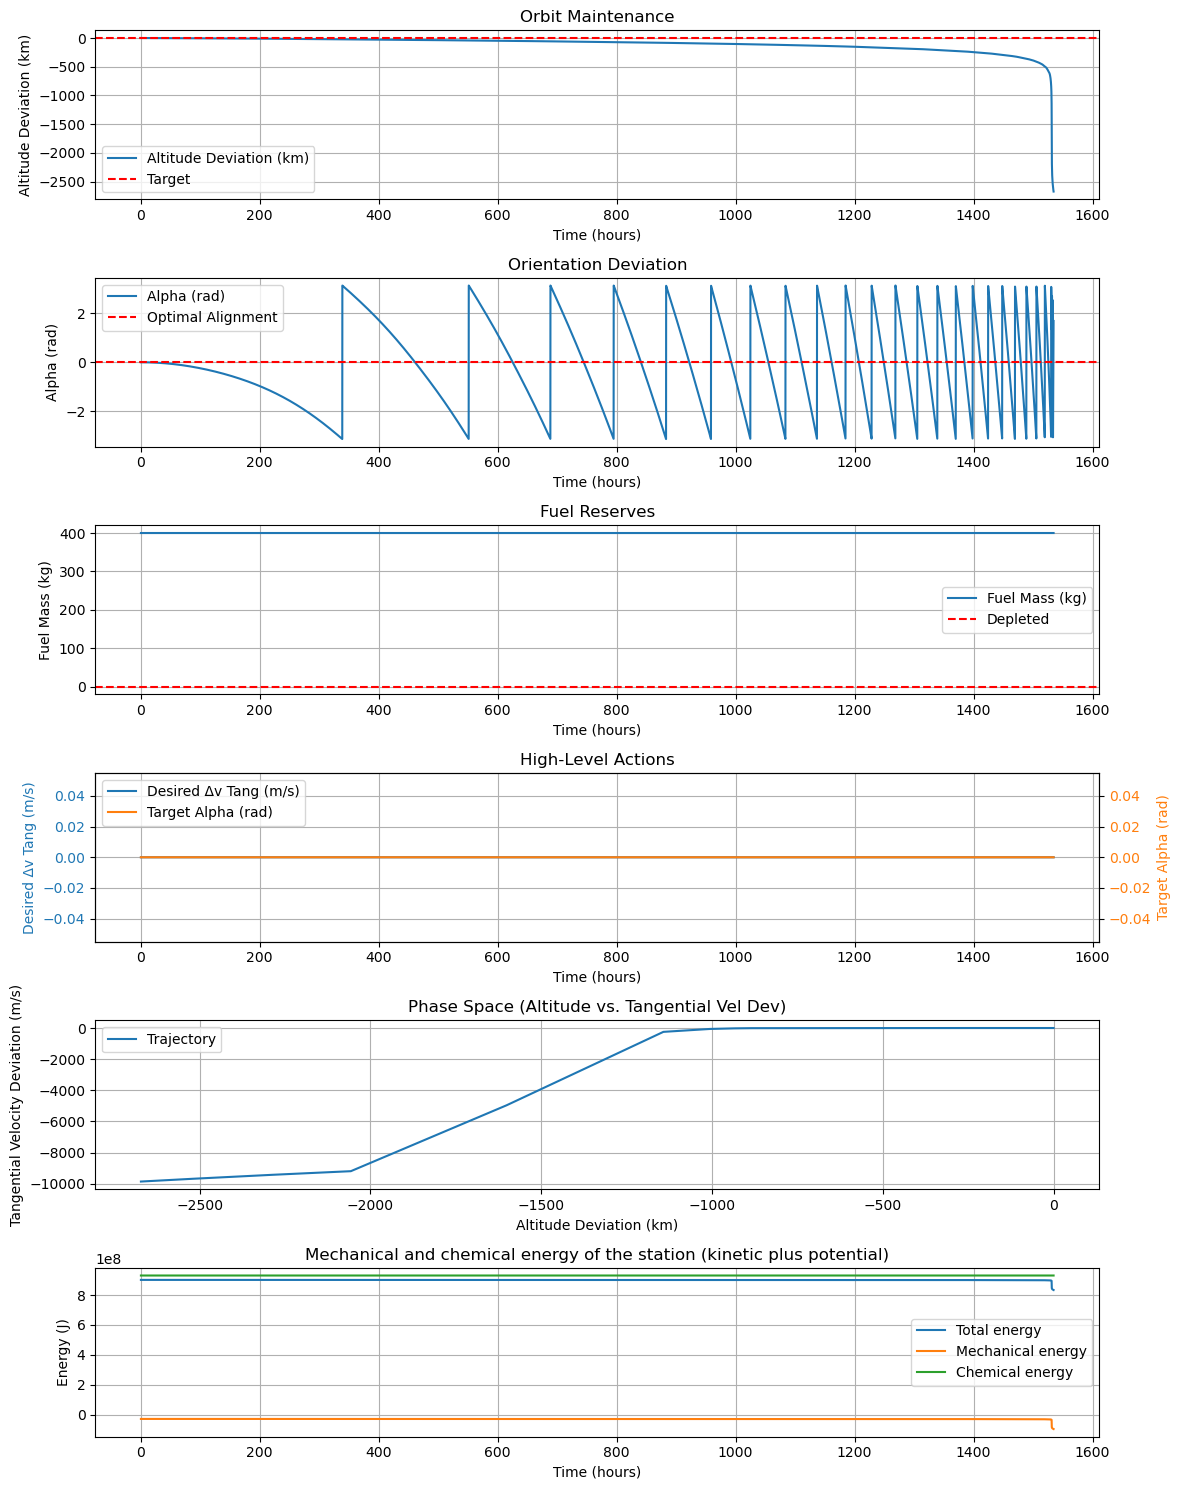

In [ ]:
# Open-Loop Simulation with Predetermined Maneuver
def open_loop_policy(obs, step):
    # NOTE: And example of a predetermined maneuver is shown below:
    # if step == 50:  # Predetermined maneuver: target alpha = pi/2 shift
    #    return np.array([0.0, 0.5])
    # else:
    #     return np.zeros(2)

    # First we assume no maneuver
    return np.zeros(2)


# Initiate and reset environment
env = OrbitMaintenanceEnv()
env.reset()

# Set PID gains to zero for open-loop (no attempt to control attitude, replace these parameters later after tuning):
env.Kp = 0
env.Ki = 0
env.Kd = 0

# Run the open-loop simulation:
open_loop_data = run_simulation(env, open_loop_policy, num_steps=10000, plot_results=True)


The above cell demonstrates the basic components of a simulation run:

- Initializing the environment (e.g. `env = OrbitMaintenanceEnv()`).
- Resetting the environment to start a new episode (e.g. `env.reset()`).
- Defining a control policy function (e.g. `open_loop_policy`).
- Running the simulation with the defined policy (e.g. `run_simulation(env, open_loop_policy`).

Here we only simulated `num_steps=10000` (although the simulation terminated before then due to the space station orbit decaying beyond recovery) instead of the default `num_steps=25920`. You may want to test ideas with such smaller time spans, then use the default full 6 months (25920 steps) for final evaluations.

The expected output printouts are:
```python
Warning: Orbit reversed or decayed severely!
terminated: True, truncated: False, step: 9207
Episode done after 9208 steps.
Days in orbit: 63.9375 days
Fuel mass remaining: 400.0 kg
Score = 164088.00390625
```

The most important value here is the "Score", which is calculated according to the rules.

# Basic reinforcement learning with PPO

The cell below demonstrates the most basic attempt to train a reinforcement learning agent using Proximal Policy Optimization (PPO) on the orbit maintenance environment. The trained model is then used to run a test simulation, and the results are plotted for analysis.

In the code below, we now replace the `open_loop_policy` with a PPO agent that learns to control the space station. The agent is trained for `50000` timesteps, which is a relatively small number for this complex task. You may want to increase this number for better performance.

> NOTE: Note that this is a very basic implementation and may not yield a high-performing agent. You are encouraged to experiment with different hyperparameters, architectures, and training strategies to improve the performance of your RL agent.

In [ ]:
# Set below to `True to train a policy`
# Train PPO (high-level)

env = OrbitMaintenanceEnv()
model = PPO("MlpPolicy", env, verbose=0, learning_rate=1e-4)
model.learn(total_timesteps=50000)


/home/stefan_endres/.anaconda3/envs/comp_eng/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


## Saving and loading the trained model

Training a model is computationally expensive, so it's a good practice to save the trained model to disk after training. This allows you to load the model later without needing to retrain it from scratch. A model can be saved using the `save` method and loaded using the `load` method from the Stable Baselines3 library as shown below:

In [ ]:
# Save the policy (rules included)
model.save("my_fancy_model_name")  # Rules saved with it

# Load and test (rules load with it)
loaded_model = PPO.load("my_fancy_model_name", env=env)  # Portable to new envs

>HINT: After loading a model you can resume training it to try and improve its performance, using, for example: `loaded_model.learn(total_timesteps=100000, reset_num_timesteps=False)`

## Testing the trained model

The model we trained needs one final wrapper before we can use it `run_simulation`. This function is then used to run a test simulation of the orbit maintenance environment, allowing you to evaluate the performance of the trained agent.

terminated: True, truncated: False, step: 8780
Episode done after 8781 steps.
Days in orbit: 60.97222222222222 days
Fuel mass remaining: 356.81467657441016 kg
Score = 142187.16094976512


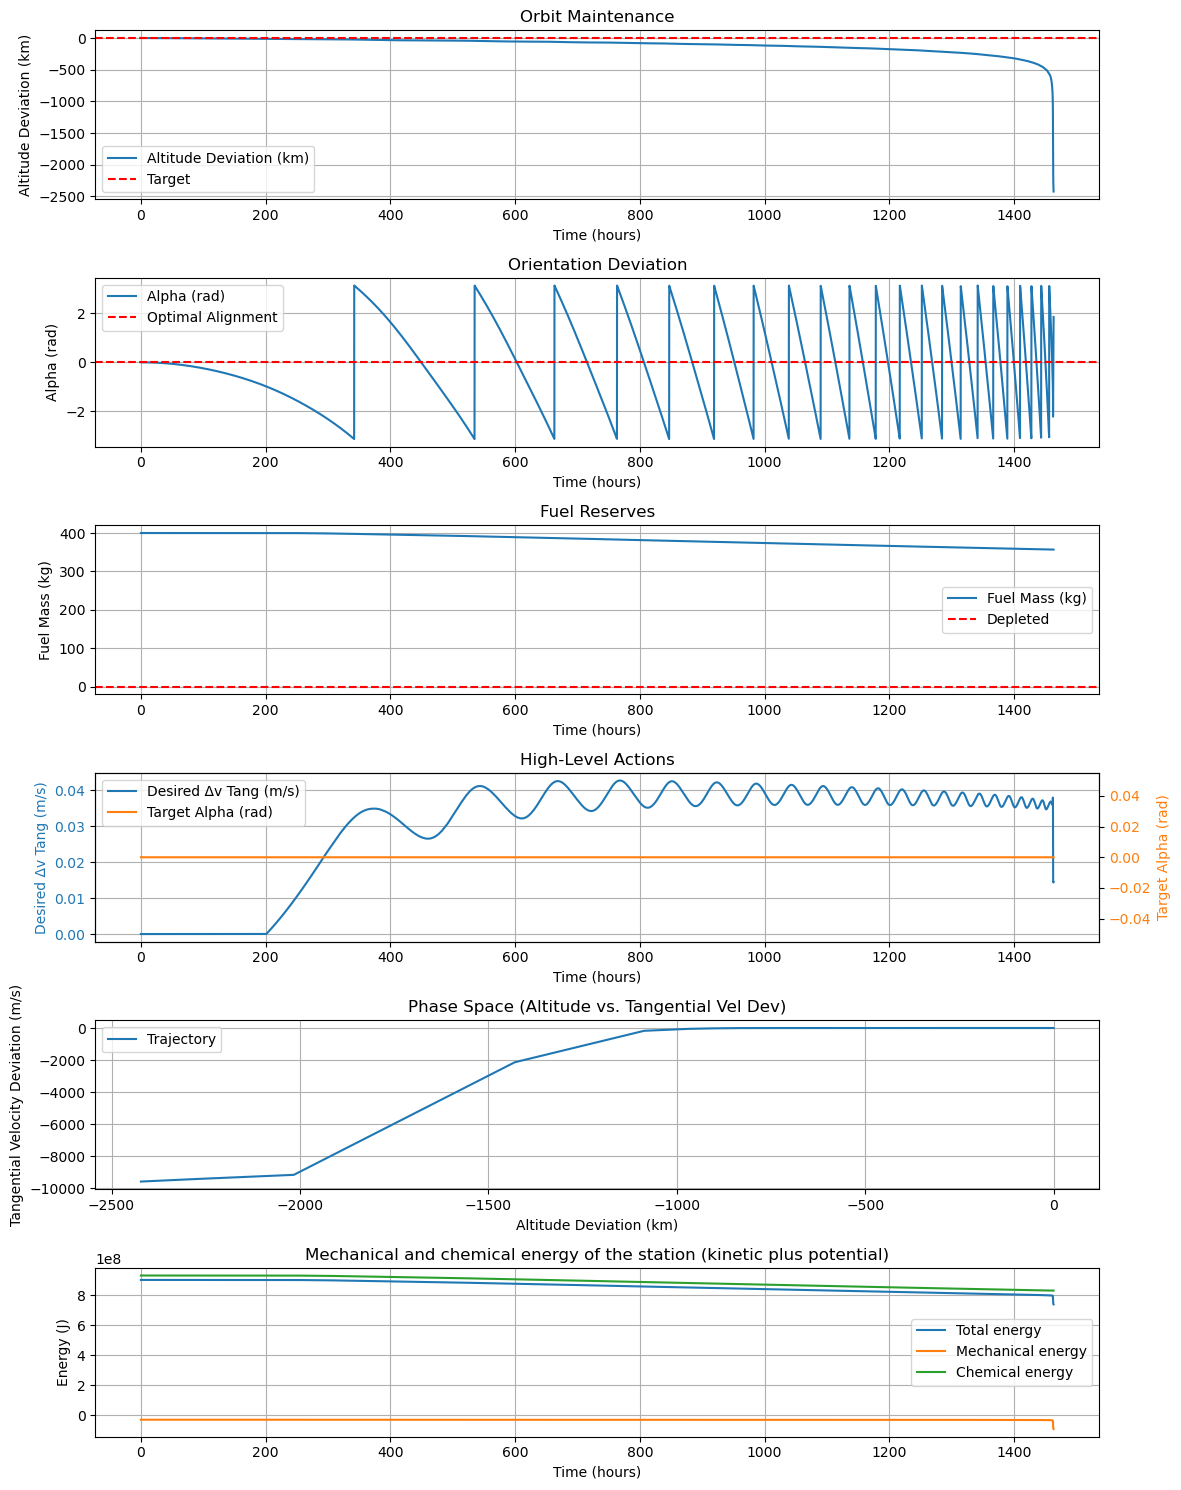

In [ ]:
# Wrapper the model for use in run_simulation:
def trained_policy(obs):
    return model.predict(obs, deterministic=True)[0]

# Run the test simulation with trained model
env.reset()
# Run the RL-agent trained simulation:
data = run_simulation(env, trained_policy)

## Reward shaping and hyperparameter tuning

Now that you have a basic RL agent working, you can experiment with different reward structures and hyperparameters to improve the performance of your agent. Consider modifying the reward function in the `OrbitMaintenanceEnv` class to better align with your objectives (e.g., minimizing fuel consumption while maintaining orbit).

Reward shaping is a crucial aspect of reinforcement learning, as it directly influences the agent's learning process. You can redefine the `reward_function` method of the `OrbitMaintenanceEnv` class to implement your custom reward structure as seen in the cell below.

>HINT: While not done in the code below, it might be useful to normalize the different components of the reward function to ensure they are on similar scales. This can help stabilize training and improve convergence while allowing you to balance the trade-offs between different objectives (e.g., altitude maintenance vs. fuel consumption) in a more controlled manner.

In [ ]:
from types import MethodType

# Initiate environment:
env = OrbitMaintenanceEnv()

# Drop-in replacement reward function:
def my_reward_function(self):
    # Example reward function (to be customized as needed)
    # Compute the current altitude deviation
    delta_alt = self.current_r - self.R_earth - self.initial_altitude  # m (altitude deviation)

    # Compute total fuel used
    total_fuel_use = self.initial_fuel_mass - self.fuel_mass

    # Compute alpha:
    v_x = self.current_v_r * np.cos(self.current_phi) - self.current_v_theta * np.sin(self.current_phi)
    v_y = self.current_v_r * np.sin(self.current_phi) + self.current_v_theta * np.cos(self.current_phi)
    alpha = self.current_psi - np.arctan2(v_y, v_x) % (2 * np.pi) - np.pi  # rad (final alpha) clampled to [-π, π]

    living_bonus = 0.05 # reward for surviving each step
    altitude_penalty = np.abs(delta_alt) / 5000.0  # tune scale (km-level deviations matter)
    fuel_penalty = 0  # Demonstrate behaviour without fuel penalty
    alignment_penalty = np.abs(alpha) * 0.2

    return living_bonus - altitude_penalty - fuel_penalty - alignment_penalty


Next, we bind the new reward function to the environment instance:

In [ ]:
env.reward_function = MethodType(my_reward_function, env)

Use the skills you have gained throughout the course to experiment with different reward structures and hyperparameters based on the idea of using penalty functions (based on knowledge of the physics) to guide the optimization with a balanced learning rate (or optimizer step size). The goal is to find a combination that leads to a high-performing agent capable of maintaining orbit for the required duration while minimizing fuel consumption.

Let's now train with the new reward function and potentially adjusted to new hyperparameters such as a tighter learning rate and more training timesteps.:

terminated: True, truncated: False, step: 9137
Episode done after 9138 steps.
Days in orbit: 63.451388888888886 days
Fuel mass remaining: 397.65295973265404 kg
Score = 174232.19139185583


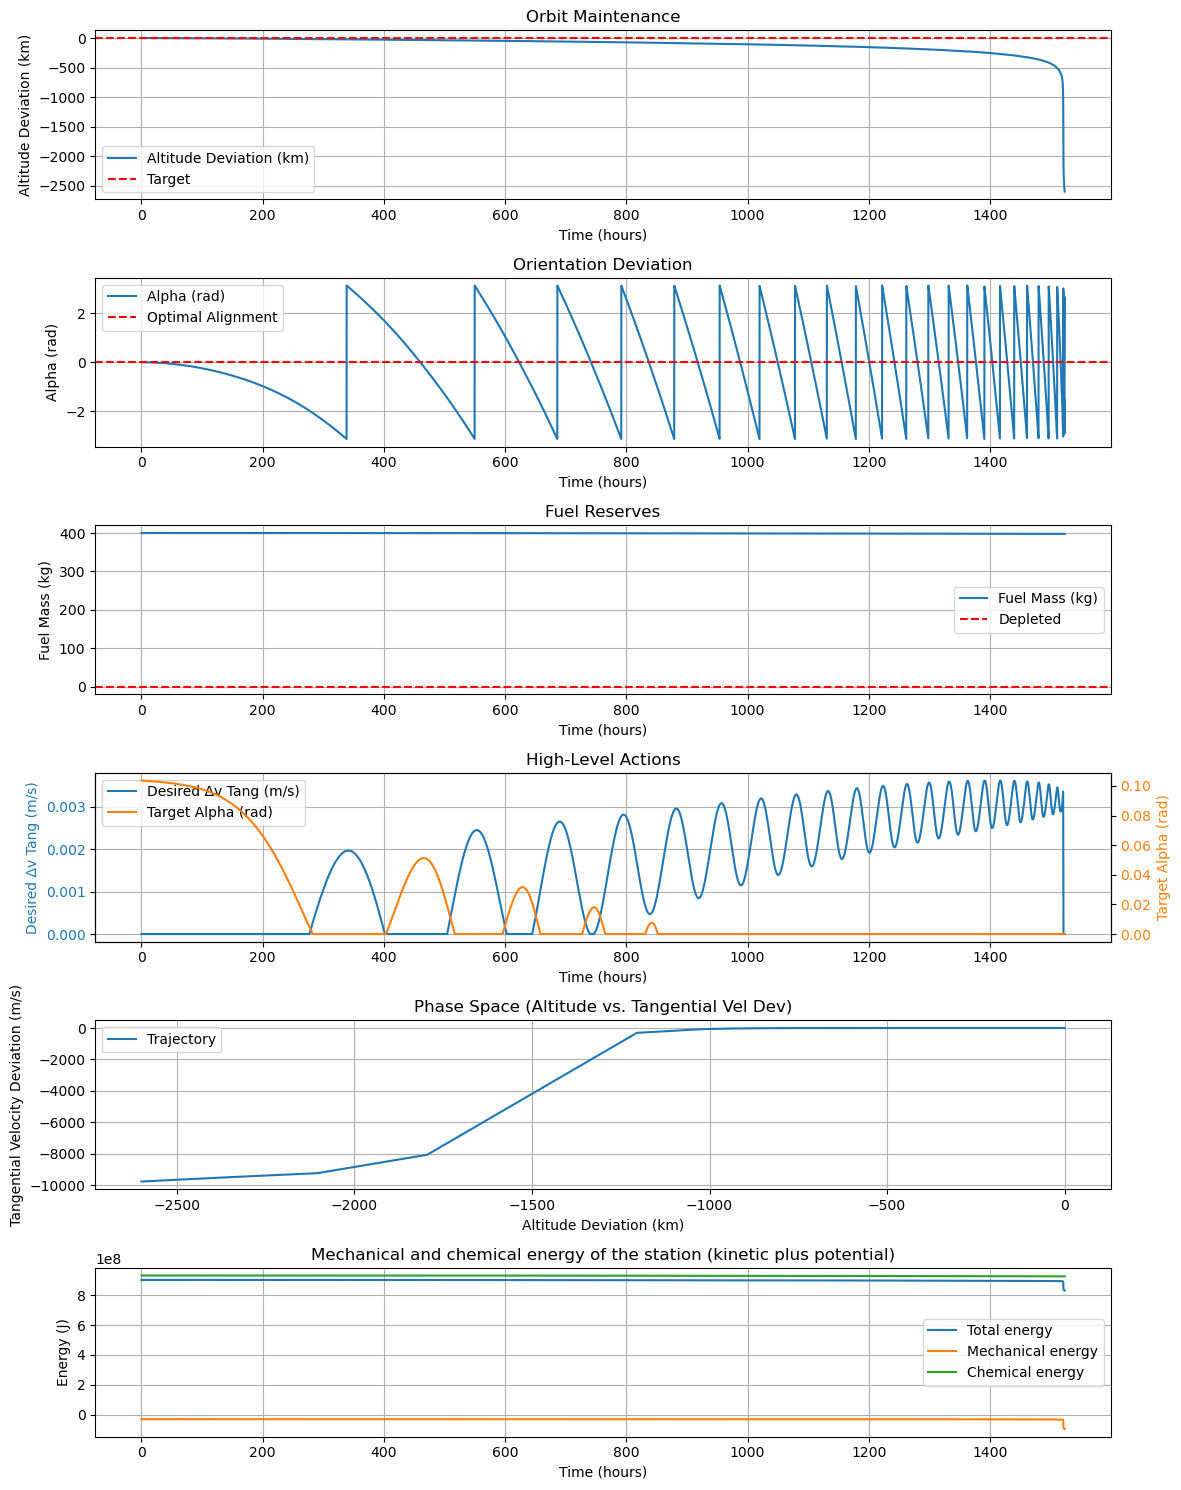

In [ ]:
env.reset()
model = PPO("MlpPolicy", env, verbose=0, learning_rate=1e-4)
model.learn(total_timesteps=5000)

# Save the policy (rules included)
model.save("my_fancy_model_name_improved")  # Rules saved with it

# Simulate new model:
def trained_policy(obs):
    return model.predict(obs, deterministic=True)[0]

# Run the RL-agent trained simulation:
data = run_simulation(env, trained_policy)


## Advanced agent structures

When we want to train more advanced structures which, for example, incorporates knowledge of the model dynamics under strict constraints, then we can also adapt base class policies such as the `ActorCriticPolicy` class. In this case we start with this class and then add hard constraints (e.g. don't use the main thruster while we are still above a deviation of -10 km).

See the code below for one such example:

In [ ]:
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3 import PPO
import torch as th
import numpy as np


class ConstrainedMlpPolicy(ActorCriticPolicy):
    def __init__(self,
        *args,
        thrust_threshold: float = -10.0,      # rule parameter (passed via policy_kwargs)
        altitude_bounds: float = 10000.0,     # scaling for delta_alt_norm → meters
        **kwargs
        ):
        # Pop custom arguments before passing the rest to the parent
        self.thrust_threshold = thrust_threshold
        self.altitude_bounds = altitude_bounds
        super().__init__(*args, **kwargs)

    def predict(
        self,
        observation: np.ndarray,
        state=None,
        episode_start=None,
        deterministic: bool = False,
        ):
        # Ensure NumPy array and add batch dimension if needed (single observation case)
        observation = np.asarray(observation)
        was_single = observation.ndim == 1
        if was_single:
            observation = observation[np.newaxis, :]  # shape (1, obs_dim)

        # Convert to tensor
        obs_tensor = th.as_tensor(observation, device=self.device).float()

        # Forward pass using the trained network (no gradient needed)
        with th.no_grad():
            features = super().extract_features(obs_tensor, self.pi_features_extractor)
            latent_pi = self.mlp_extractor.forward_actor(features)
            distribution = self._get_action_dist_from_latent(latent_pi)
            actions_tensor = distribution.get_actions(deterministic=deterministic)

        # Back to NumPy for constraint application
        actions = actions_tensor.cpu().numpy()
        obs_np = observation  # already NumPy, shape (batch, obs_dim)

        # Hard constraint logic:
        if 1:
            # Assuming obs[..., 0] is normalized delta_altitude
            delta_alt = obs_np[:, 0] # * self.altitude_bounds
            mask = delta_alt > self.thrust_threshold
            # e.g. only thrust when significantly low
            actions[mask, 0] = 0.0                                      # zero the thrust-related action
        else:
            delta_alt = obs_np[:, 0] * self.altitude_bounds   # unnormalize, shape (batch,)

            # NEW: No thrust when deviation STILL ABOVE threshold (-100)
            # i.e. thrust ONLY when delta_alt <= threshold (critically low)
            no_thrust_mask = delta_alt > self.thrust_threshold
            actions[no_thrust_mask, 0] = 0.0


        # Optional additional rule (commented as in your original intent)
        # actions[mask, 1] = 0.0  # e.g. zero angle for minimum drag during coast
        actions[:, 1] = 0.0

        # Remove batch dim if we added it
        if was_single:
            actions = actions[0]

        return actions, state

In order to train this policy we need to pass it to the PPO agent along with any custom parameters (e.g., `thrust_threshold`). The code below demonstrates how to set up and train the PPO agent using the `ConstrainedMlpPolicy`.

In [ ]:
# Reinitiate the environment
env = OrbitMaintenanceEnv()
env.reset()

# Change PID Loop params
env.Kp = 0.1
env.Ki = 0.01
env.Kd = 0.1

# Train PPO with custom policy
model = PPO(
    ConstrainedMlpPolicy,  # Use custom class
    env,
    verbose=0,
    learning_rate=1e-4,
    policy_kwargs={
        'net_arch': [64, 64],  # Your default MLP (customizable)
        'activation_fn': th.nn.Tanh,  # Standard for MlpPolicy
        'thrust_threshold': -10.0  # Pass rule param to policy init
    }
)

# We can not train as normal:
model.learn(total_timesteps=5000)

# Save the policy (rules included)
model.save("constrained_ppo_orbit")

The simulation can now be run using code like below

terminated: True, truncated: False, step: 9037
Episode done after 9038 steps.
Days in orbit: 62.75694444444445 days
Fuel mass remaining: 352.8078959747771 kg
Score = 140227.1477661615


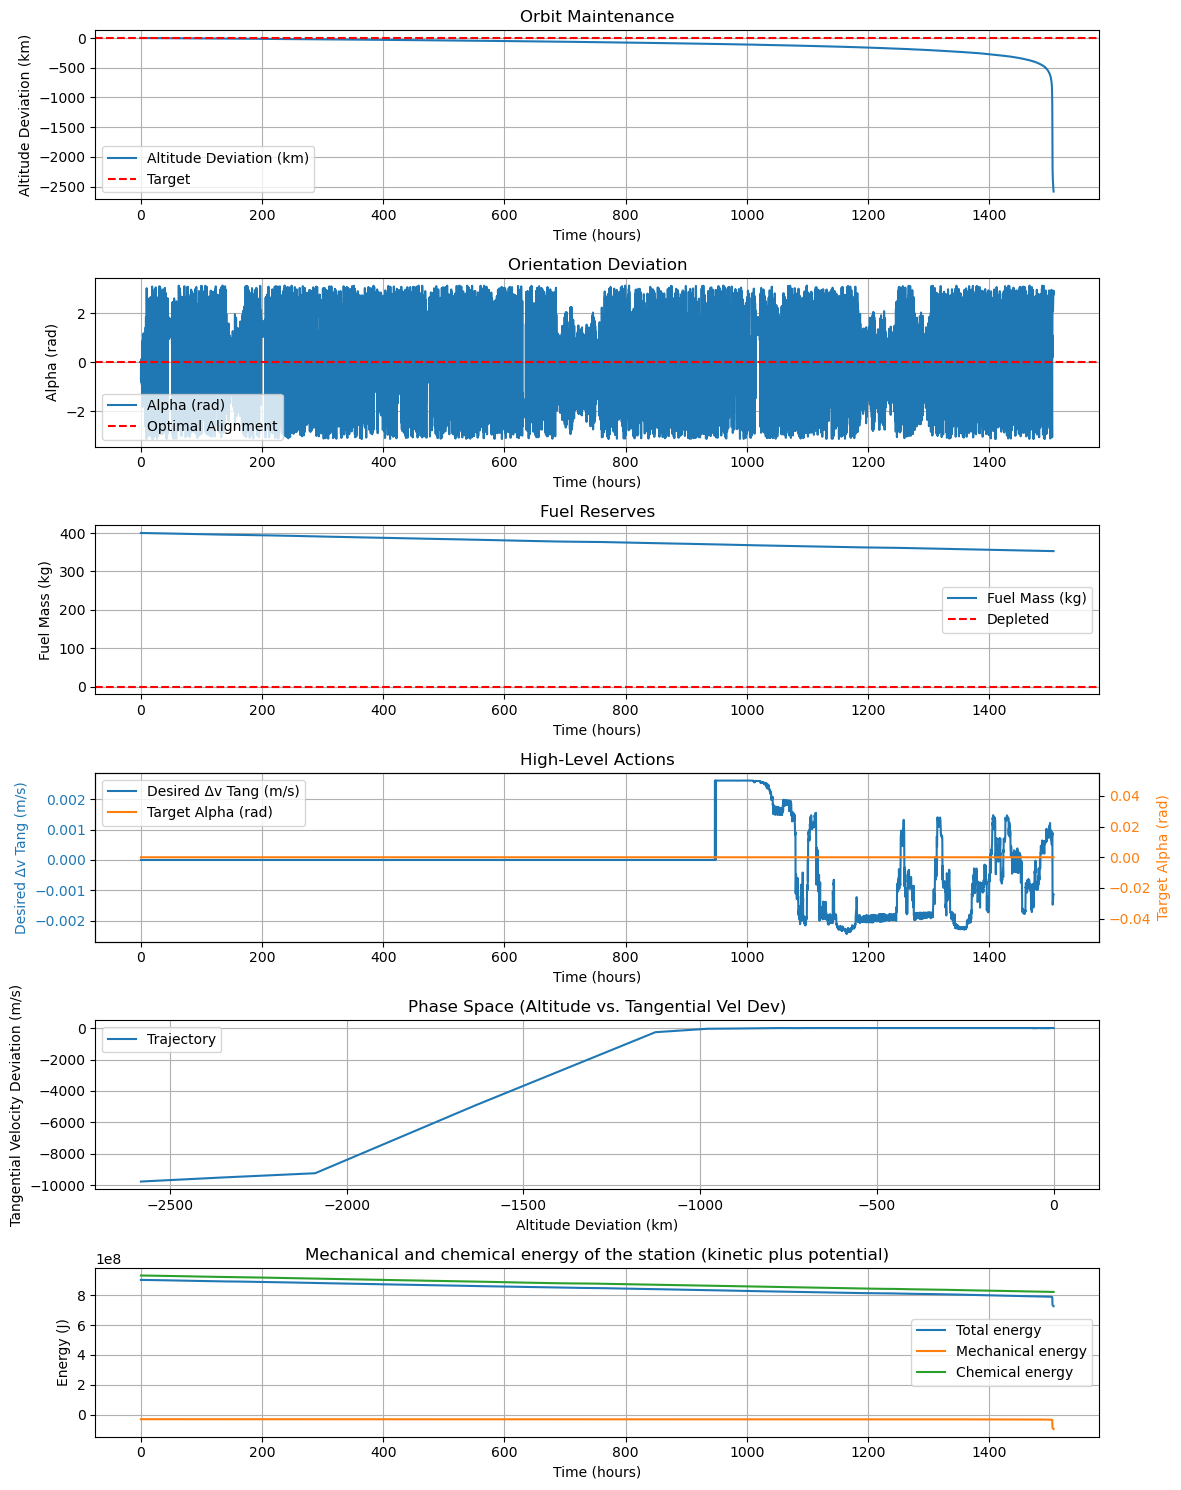

In [ ]:
# Load and test (rules load with it)
# Create a dummy model with the exact same configuration as during training
loaded_model = PPO(
    ConstrainedMlpPolicy,
    env,
    policy_kwargs={
        "net_arch": [64, 64],
        "activation_fn": th.nn.Tanh,
        "thrust_threshold": -10.0,
        "altitude_bounds": 10000.0,
    },
)

# Load only the trained parameters (this preserves the custom policy logic)
loaded_model.set_parameters("constrained_ppo_orbit")

def constrained_policy(obs):
    action, _ = loaded_model.predict(obs, deterministic=True)
    return action

env.reset()
data = run_simulation(env, constrained_policy)

### Additional: Saving in colab

The code for saving models above saves them locally, to save your files on Colab's cloud you can use:

In [ ]:
from google.colab import drive
import shutil
import zipfile

# Mount Google Drive (only once per session)
drive.mount('/content/drive')

# Example save path
model_dir = "/content/drive/MyDrive/RL_Station_Models/my_ppo_agent"
zip_path = "/content/drive/MyDrive/RL_Station_Models/my_ppo_agent.zip"

# After training:
model.save(model_dir)                    # stable-baselines3 save

# Zip it (clean single file)
shutil.make_archive(base_name=model_dir, format='zip', root_dir=model_dir)

print(f"Model saved and zipped to: {zip_path}")

loading

In [ ]:
# Mount Drive if not already
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/RL_Station_Models/my_ppo_agent.zip"
extract_dir = "my_ppo_agent"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")

# Load model
from stable_baselines3 import PPO
model = PPO.load("my_ppo_agent")   # or whatever the extracted folder name is

Local / offline is simpler (just keep it all in the same directory):

In [ ]:
import shutil
import zipfile

# Save
model.save("my_ppo_agent")
shutil.make_archive("my_ppo_agent", 'zip', "my_ppo_agent")

# Load
with zipfile.ZipFile("my_ppo_agent.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
model = PPO.load("my_ppo_agent")